# I. Setup pour l'analyse

In [2]:
#import
from sqlalchemy import text, create_engine
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from unidecode import unidecode
# import unidecode

from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

# modèle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pickle




## Import dataset

In [29]:
data = pd.read_csv("data/dataset.csv", sep = ",")
data.dropna(subset=['certificate_eligible', 'grade'], inplace = True)

data = data.drop("total_length", axis=1)


(5349, 11)


,user,gender,country,level_of_education,course_id,nb_threads,nb_comments,corpus,delai_1er_post,grade,certificate_eligible
10,-Luca-,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session03,0,1,"Bonjour, je m'appelle Luca, je suis consultant...",5,0.38,N
44,0cbr,NaN,NaN,NaN,course-v1:MinesTelecom+04018+session03,0,1,"Bonjour,\nJ'ai le même type de pb .\nJe n arri...",28,0.80,Y
46,0cbr,NaN,NaN,NaN,MinesTelecom/04021S02/session02,1,0,Beaucoup de temps passé sur le net pour compre...,26,0.35,N
57,123AZER,NaN,NaN,NaN,CNAM/01002S04/session04,1,0,"Bonjour, Nicolas 50 ans Officier de Sapeurs-Po...",10,0.77,Y
68,12nono12,NaN,NaN,NaN,MinesTelecom/04017S02/session02,0,1,"En fait dans le simulateur, le servo moteur se...",31,0.98,Y


In [30]:
#drop l'outlier EGo41
data = data[data.user != "EGo41"]
data.shape

(5335, 11)

In [69]:
data.head(10)

,user,gender,country,level_of_education,course_id,nb_threads,nb_comments,corpus,delai_1er_post,grade,certificate_eligible,polarity,subjectivity
10,-Luca-,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session03,0,1,"bonjour, je m'appelle luca, je suis consultant...",5,0.38,0,0.126667,0.275000
44,0cbr,NaN,NaN,NaN,course-v1:MinesTelecom+04018+session03,0,1,"bonjour,\nj'ai le meme type de pb .\nje n arri...",28,0.80,1,-0.200000,0.300000
46,0cbr,NaN,NaN,NaN,MinesTelecom/04021S02/session02,1,0,beaucoup de temps passe sur le net pour compre...,26,0.35,0,0.043750,0.325000
57,123AZER,NaN,NaN,NaN,CNAM/01002S04/session04,1,0,"bonjour, nicolas 50 ans officier de sapeurs-po...",10,0.77,1,0.174286,0.278571
68,12nono12,NaN,NaN,NaN,MinesTelecom/04017S02/session02,0,1,"en fait dans le simulateur, le servo moteur se...",31,0.98,1,0.015000,0.175000
89,181250,NaN,NaN,NaN,course-v1:MinesTelecom+04021+session03,1,0,je m'appelle joel et je suis retraite depuis 6...,9,0.92,0,0.521875,0.400000
94,1943,NaN,NaN,NaN,MinesTelecom/04017S02/session02,2,0,"bonjour, j'ai effectue les feux tricolor sur s...",10,0.13,0,-0.240000,0.400000
95,1943,NaN,NaN,NaN,MinesTelecom/04021/session01,2,1,"bonjour,\nje suis sur mac osx 10,12 sierra et ...",0,0.90,1,0.030000,0.220000
129,20150094,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session03,1,0,bonjour ;\n j'ai une question : \npourquoi le ...,21,0.43,0,-0.100000,0.000000
135,21GG21,NaN,NaN,NaN,course-v1:MinesTelecom+04021+session03,0,3,"bonsoir,\n\npour grouper les objets, tu clique...",10,0.97,1,0.074444,0.200000


## dataset preproc

In [32]:
# encode le label
data['certificate_eligible'] = LabelEncoder().fit_transform(data['certificate_eligible'])

#prépare le corpus pour textblob
data["corpus"]= data["corpus"].str.lower()
# envlever les accents
unidec_corpus = []
for (i, row) in data.iterrows():
    truc = unidecode(row['corpus'])
    # print(f"user: {row['user']} course :{row['course_id']} new_corp:{truc[:25]}")
    unidec_corpus.append(truc)

data["corpus"] = unidec_corpus

In [33]:
# application de l'analyse de sentiments
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

polarity = []
subjectivity = []

# avec version Emmanuel
for (i, row) in data.iterrows():
    # if i>10: quit()
    blob = tb(row['corpus'])
    # print(f"user: {row['user']} course :{row['course_id']} sentiment:{blob.sentiment}")
    polarity.append(blob.sentiment[0])
    subjectivity.append(blob.sentiment[1])


#update le dataset avec les nouvelles valeurs
data['polarity']=polarity
data['subjectivity']=subjectivity

data.head()

,user,gender,country,level_of_education,course_id,nb_threads,nb_comments,corpus,delai_1er_post,grade,certificate_eligible,polarity,subjectivity
10,-Luca-,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session03,0,1,"bonjour, je m'appelle luca, je suis consultant...",5,0.38,0,0.126667,0.275000
44,0cbr,NaN,NaN,NaN,course-v1:MinesTelecom+04018+session03,0,1,"bonjour,\nj'ai le meme type de pb .\nje n arri...",28,0.80,1,-0.200000,0.300000
46,0cbr,NaN,NaN,NaN,MinesTelecom/04021S02/session02,1,0,beaucoup de temps passe sur le net pour compre...,26,0.35,0,0.043750,0.325000
57,123AZER,NaN,NaN,NaN,CNAM/01002S04/session04,1,0,"bonjour, nicolas 50 ans officier de sapeurs-po...",10,0.77,1,0.174286,0.278571
68,12nono12,NaN,NaN,NaN,MinesTelecom/04017S02/session02,0,1,"en fait dans le simulateur, le servo moteur se...",31,0.98,1,0.015000,0.175000


In [34]:
data.shape

(5335, 13)

# II. Modèle

## 1 Classification

In [35]:
from pycaret.classification import *

In [36]:
data_class = data.drop(['user', 'course_id', 'corpus','grade'], axis=1)
data_class.head()

,gender,country,level_of_education,nb_threads,nb_comments,delai_1er_post,certificate_eligible,polarity,subjectivity
10,NaN,NaN,NaN,0,1,5,0,0.126667,0.275000
44,NaN,NaN,NaN,0,1,28,1,-0.200000,0.300000
46,NaN,NaN,NaN,1,0,26,0,0.043750,0.325000
57,NaN,NaN,NaN,1,0,10,1,0.174286,0.278571
68,NaN,NaN,NaN,0,1,31,1,0.015000,0.175000


In [37]:
s = setup(data_class, target = 'certificate_eligible')

,Description,Value
0,session_id,5946
1,Target,certificate_eligible
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5335, 9)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [38]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6682,0.6894,0.8210,0.6961,0.7531,0.2576,0.2662,0.2010
ada,Ada Boost Classifier,0.6588,0.6806,0.8127,0.6896,0.7460,0.2371,0.2446,0.0950
lightgbm,Light Gradient Boosting Machine,0.6586,0.6734,0.7862,0.6982,0.7394,0.2492,0.2531,0.0570
rf,Random Forest Classifier,0.6484,0.6519,0.7831,0.6889,0.7328,0.2245,0.2289,0.2720
et,Extra Trees Classifier,0.6390,0.6437,0.7597,0.6876,0.7217,0.2115,0.2139,0.2770
lr,Logistic Regression,0.6302,0.6568,0.9722,0.6295,0.7641,0.0635,0.1220,0.4860
lda,Linear Discriminant Analysis,0.6227,0.6051,0.9900,0.6217,0.7638,0.0278,0.0886,0.0250
ridge,Ridge Classifier,0.6221,0.0000,0.9874,0.6218,0.7630,0.0280,0.0801,0.0100
nb,Naive Bayes,0.6213,0.5859,0.9926,0.6205,0.7636,0.0217,0.0788,0.0100
dummy,Dummy Classifier,0.6162,0.5000,1.0000,0.6162,0.7626,0.0000,0.0000,0.0070


In [70]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [41]:
print(best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5946, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [42]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6933,0.7251,0.8287,0.7228,0.7722,0.3098,0.3166


,nb_threads,nb_comments,delai_1er_post,polarity,subjectivity,gender_f,gender_m,gender_not_available,country_AD,country_AU,...,level_of_education_hs,level_of_education_jhs,level_of_education_m,level_of_education_none,level_of_education_not_available,level_of_education_other,level_of_education_p,certificate_eligible,Label,Score
0,0.0,1.0,15.0,0.300000,0.200000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.6419
1,11.0,0.0,13.0,0.213529,0.208824,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0.5882
2,1.0,0.0,86.0,0.036667,0.483333,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7164
3,1.0,0.0,0.0,0.220000,0.133333,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.5983
4,1.0,0.0,25.0,0.047500,0.215000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0.5557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,0.0,2.0,9.0,0.160000,0.150000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.6696
1597,0.0,4.0,16.0,0.055714,0.225714,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7749
1598,0.0,1.0,17.0,0.063000,0.235000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.6693
1599,0.0,1.0,3.0,0.125000,0.166667,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.5929


In [43]:
# export model
save_model(best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='certificate_eligible',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
                                             

## 2 Regression

In [6]:
data_class = data.drop(['user', 'course_id', 'corpus','certificate_eligible'], axis=1)
data_class.head()

,gender,country,level_of_education,nb_threads,nb_comments,delai_1er_post,total_length,grade,polarity,subjectivity
10,NaN,NaN,NaN,0,1,5,554,0.38,0.126667,0.275000
44,NaN,NaN,NaN,0,1,28,213,0.80,-0.200000,0.300000
46,NaN,NaN,NaN,1,0,26,216,0.35,0.043750,0.325000
57,NaN,NaN,NaN,1,0,10,336,0.77,0.174286,0.278571
68,NaN,NaN,NaN,0,1,31,261,0.98,0.015000,0.175000


In [7]:
from pycaret.regression import *


In [13]:
s = pycaret.regression.setup(data_class, target = 'grade')

,Description,Value
0,session_id,6335
1,Target,grade
2,Original Data,"(5349, 10)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3744, 55)"


In [14]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2891,0.1140,0.3376,0.1463,0.2324,0.8022,0.2150
ada,AdaBoost Regressor,0.3068,0.1189,0.3448,0.1100,0.2353,0.8043,0.0500
lightgbm,Light Gradient Boosting Machine,0.2911,0.1202,0.3466,0.1001,0.2375,0.7952,0.0560
rf,Random Forest Regressor,0.2945,0.1225,0.3498,0.0834,0.2395,0.8093,0.6460
et,Extra Trees Regressor,0.2981,0.1291,0.3592,0.0340,0.2451,0.8146,0.4920
br,Bayesian Ridge,0.3191,0.1306,0.3613,0.0226,0.2475,0.8889,0.0150
ridge,Ridge Regression,0.3181,0.1306,0.3614,0.0222,0.2472,0.8877,0.0090
lr,Linear Regression,0.3184,0.1312,0.3621,0.0181,0.2476,0.8909,0.3020
lar,Least Angle Regression,0.3185,0.1313,0.3623,0.0171,0.2478,0.8931,0.0130
omp,Orthogonal Matching Pursuit,0.3225,0.1326,0.3641,0.0077,0.2498,0.9068,0.0080


In [15]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

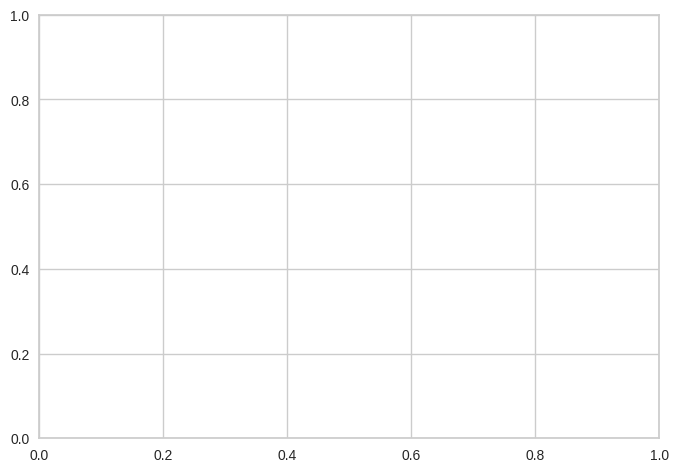

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=6335, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [16]:
print(best)

In [ ]:
predict_model(best)

# III. Prediction

In [44]:
# charger le modèle
loaded_model = load_model('my_best_pipeline')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='certificate_eligible',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
       

In [66]:
# soit cette liste l'ensemble des données entrées par l'utilisateur dans le formulaire
gender = "f"
country = np.NaN
level_of_education = np.NaN
nb_threads = 2
nb_comments = 5
# corpus = "c'est un roc, c'est un pic, c'est un cap, que dis-je c'est un cap, c'est une péninsule!"
corpus = "c'est nul, je n'aime pas, je suis subjectif et négatif"
delai_1er_post = 2

In [62]:
# prétraitement du corpus

#lower case
corpus = corpus.lower()
# envlever les accents
corpus= unidecode(corpus)

In [63]:
# analyse de sentiments
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
blob = tb(corpus)

polarity = (blob.sentiment[0])
subjectivity = (blob.sentiment[1])


In [67]:
# définition du df pour la prédiction
input = [gender, country, level_of_education, nb_threads, nb_comments, corpus, delai_1er_post, polarity, subjectivity]

df_input = pd.DataFrame(np.array([input]),
                    columns=["gender", "country", "level_of_education", "nb_threads", "nb_comments", "corpus", "delai_1er_post", "polarity", "subjectivity"])
df_input

,gender,country,level_of_education,nb_threads,nb_comments,corpus,delai_1er_post,polarity,subjectivity
0,f,nan,nan,2,5,"c'est nul, je n'aime pas, je suis subjectif et...",2,0.09999999999999998,0.20000000000000004


In [68]:
# prediction avec le modele
y_pred = loaded_model.predict(df_input)

# print(f"y pred = {y_pred}")

if y_pred == [1]:
    print("Cet utilisateur devrait valider le diplome")
else: 
    print("Cet utilisateur ne devrait pas valider le diplome")

Cet utilisateur devrait valider le diplome
